In [ ]:
%matplotlib inline

Нейронный перенос стиля с Pytorch
============================
**Aвтор**: `Alexis Jacq <https://alexis-jacq.github.io>` <br />
**Адаптивный перевод**: `Zueva Nadya <https://github.com/nestyme>` <br />
Введение
------------

В этом ноутбуке объясняется и показывается, как работает алгоритм переноса стиля 

`Neural-Style <https://arxiv.org/abs/1508.06576>` 

Леона А. Гатиса, Александра С. Эккера и Маттиаса Бетге.


**Нейронный перенос стиля** -- это алгоритм, который принимает контент-изображение (например, черепаху), стиль-изображение (например, картинку известного художника) и возвращает изображение, которое будто бы нарисовано тем художником:



**Как это работает?**

Всего есть три картинки: вход, стиль и контент. 
Определим два расстояния: 
- $D_S$ - оно определяет на сколько разные стили у двух произвольных картинок.
- $D_C$ - оно определяет на сколько разнится контент у двух произвольных картинок.

задача сети - минимизировать $D_S$ от входной картинки до стиля и $D_C$ от входной картиники до контента.<br />
В качестве входа обычно берется зашумленная к
артинка контента.


Это все что нам понадобится:

In [49]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import numpy as np

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Загрузка изображений
------------------
Нам понадобятся картинки стиля и контента, так что загрузим их.<br />
Чтобы упростить реализацию, начнем с контента и стиля одного размера. Затем мы масштабируем их до требуемых размеров выходного изображения.

Примеры изображений лежат в папке `Images` на гуглдиске

Вы можете добавить туда свои собственные изображения -- главное, чтобы они были одного размера

In [51]:
# desired size of the output image
imsize = 512 

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()])


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img_1 = image_loader('./style_1.jpg')
style_img_2 = image_loader('./style_2.jpeg')
content_img = image_loader('./content.jpeg')

# Код генерации маски

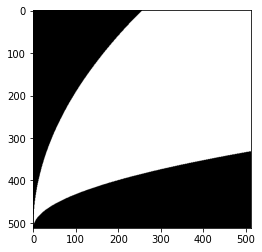

In [52]:
def generate_mask(type, imsize=512):
    mask = torch.zeros((imsize, imsize))

    def fun(row_id, column_id):
        value = column_id * np.sin(column_id) * np.sin(column_id)
        result = 8 * np.sqrt(column_id) <= np.abs(row_id - imsize) <= 32 * np.sqrt(column_id)
        return result if type == 1 else not result

    mask = np.array([[fun(row_id, column_id) for column_id in range(imsize)] for row_id in range(imsize)], dtype=np.float32)

    return torch.from_numpy(mask)

plt.imshow(transforms.ToPILImage()(generate_mask(1)), cmap='gray')

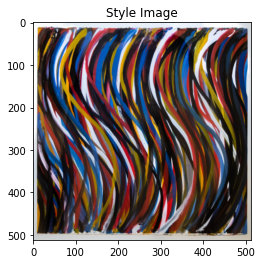

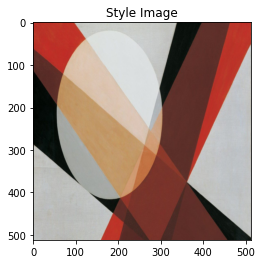

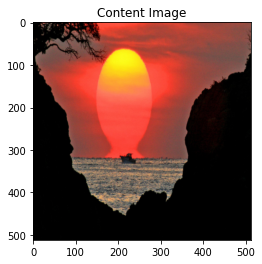

In [53]:
unloader = transforms.ToPILImage()  

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
imshow(style_img_1, title='Style Image')

plt.figure()
imshow(style_img_2, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Функции потерь
--------------
Контент лосс

In [54]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Стайл лосс

In [55]:
def gram_matrix(input):
    batch_size, h, w, f_map_num = input.size()  # batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(batch_size * h * w * f_map_num)

In [64]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature, type):
        super(StyleLoss, self).__init__()
        mask = generate_mask(type)
        self.mask = mask.to(device)
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        shape_of_input = input.shape
        mask = torch.stack([self.mask for _ in range(shape_of_input[1])], dim=0)
        mask = mask.unsqueeze(0)
        mask = transforms.Resize((shape_of_input[2], shape_of_input[3]))(mask)
        G = gram_matrix(input * mask)
        self.loss = F.mse_loss(G, self.target)
        return input

Импорт модели
-------------------
Определим предобученную модель

In [66]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [67]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [68]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img_1, style_img_2, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature_1 = model(style_img_1).detach()
            style_loss_1 = StyleLoss(target_feature_1, 1)
            model.add_module("style_loss_1_{}".format(i), style_loss_1)

            target_feature_2 = model(style_img_2).detach()
            style_loss_2 = StyleLoss(target_feature_2, 2)
            model.add_module("style_loss_2_{}".format(i), style_loss_2)
            style_losses.append((style_loss_1, style_loss_2))

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

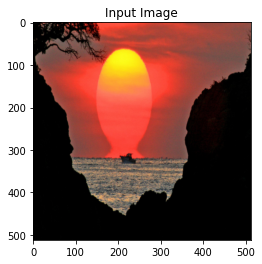

In [69]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Градиентный спуск
----------------


In [70]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

Дальше стандартный цикл обучения, но что это за closure?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [71]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img_1, style_img_2, input_img, num_steps=300,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img_1, style_img_2, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl_1, sl_2 in style_losses:
                style_score += sl_1.loss + sl_2.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 228.598297 Content Loss: 38.104237

run [100]:
Style Loss : 57.972076 Content Loss: 41.347820

run [150]:
Style Loss : 28.921087 Content Loss: 41.335232

run [200]:
Style Loss : 19.990900 Content Loss: 40.550934

run [250]:
Style Loss : 15.725708 Content Loss: 39.961647

run [300]:
Style Loss : 13.671891 Content Loss: 39.402920



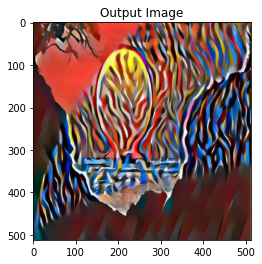

In [72]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img_1, style_img_2, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()